In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import seaborn as sns

# Data Preprocessing

In [25]:
df = pd.read_csv('./archive/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


0    284315
1       492
Name: Class, dtype: int64
----------------------------------------------
0    99.827251
1     0.172749
Name: Class, dtype: float64


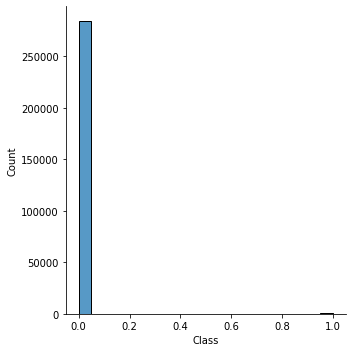

In [26]:
print(df['Class'].value_counts())
print('----------------------------------------------')
print(df['Class'].value_counts(normalize=True) * 100)
df = df.drop('Time', axis=1)
df_pos = df[df['Class'] == 0]
df_pos = df_pos.sample(frac=1)
df_neg = df[df['Class'] == 1]
df_neg = df_neg.sample(frac=1)
sns.displot(df['Class'])

## Data Inbalance

In [27]:
batch_size = 128

# Train set
train_set = df_pos.copy()
train_target = train_set['Class']
train_set = train_set.drop('Class', axis=1)
train_set.reset_index(drop=True, inplace=True)

In [28]:
# Train Loader
train = torch.tensor(train_set.values.astype(np.float32))
target = torch.tensor(train_target.values.astype(np.float32))
train_set = torch.utils.data.TensorDataset(train, target)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

# Build Model

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(29, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Linear(96, 16),
            nn.ReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(16, 96),
            nn.ReLU(),
            nn.Linear(96, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 29),
        )
    def forward(self, inputs):
        codes = self.Encoder(inputs)
        decoded = self.Decoder(codes)
        return codes, decoded

## Optimizer and loss function

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)

LR = 3e-4
Epoch = 50
criterion = nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training AutoEncoder

In [31]:
from tqdm import tqdm
for i in range(Epoch):
    train_loss = 0.0
    for idx, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        codes, decoded = model(inputs)
        
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Show progress
        if idx % 2000 == 0:
            print('[{}/{}] Loss:'.format(i+1, Epoch), train_loss / 2000)
            train_loss = 0.0
    scheduler.step()
# Save
torch.save(model, 'autoencoder.pth')

  2%|▏         | 46/2222 [00:00<00:09, 224.81it/s]

[1/50] Loss: 2.5996142578125


 91%|█████████ | 2027/2222 [00:08<00:00, 236.55it/s]

[1/50] Loss: 52.95404709540308


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[2/50] Loss: 0.00032394605875015256


 91%|█████████▏| 2032/2222 [00:08<00:00, 238.69it/s]

[2/50] Loss: 2.6842070542126892


  2%|▏         | 48/2222 [00:00<00:09, 238.80it/s]

[3/50] Loss: 0.0003161974847316742


 92%|█████████▏| 2045/2222 [00:08<00:00, 239.78it/s]

[3/50] Loss: 3.638219336539507


  2%|▏         | 48/2222 [00:00<00:09, 239.78it/s]

[4/50] Loss: 0.00027355295419692995


 92%|█████████▏| 2042/2222 [00:08<00:00, 237.85it/s]

[4/50] Loss: 1.2048288703709842


  2%|▏         | 48/2222 [00:00<00:09, 238.80it/s]

[5/50] Loss: 0.000265900582075119


 91%|█████████ | 2026/2222 [00:08<00:00, 238.79it/s]

[5/50] Loss: 1.2268219218999148


  1%|          | 23/2222 [00:00<00:09, 227.52it/s]

[6/50] Loss: 0.0002321382611989975


 91%|█████████ | 2018/2222 [00:08<00:00, 237.46it/s]

[6/50] Loss: 1.3501999250948429


  2%|▏         | 48/2222 [00:00<00:09, 235.10it/s]

[7/50] Loss: 0.00020002409815788268


 92%|█████████▏| 2044/2222 [00:08<00:00, 237.82it/s]

[7/50] Loss: 0.9377319191172719


  2%|▏         | 48/2222 [00:00<00:09, 237.82it/s]

[8/50] Loss: 0.00022495990991592407


 92%|█████████▏| 2043/2222 [00:08<00:00, 239.00it/s]

[8/50] Loss: 0.7304787544608116


  2%|▏         | 48/2222 [00:00<00:09, 238.80it/s]

[9/50] Loss: 0.00023425355553627014


 91%|█████████ | 2027/2222 [00:08<00:00, 238.20it/s]

[9/50] Loss: 0.6469733810946345


  1%|          | 24/2222 [00:00<00:09, 235.08it/s]

[10/50] Loss: 0.00016726745665073396


 92%|█████████▏| 2046/2222 [00:08<00:00, 237.00it/s]

[10/50] Loss: 0.6503340215086937


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[11/50] Loss: 0.00015549810230731963


 92%|█████████▏| 2045/2222 [00:08<00:00, 238.95it/s]

[11/50] Loss: 0.5550326369479298


  2%|▏         | 48/2222 [00:00<00:09, 239.78it/s]

[12/50] Loss: 0.0001578185260295868


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.07it/s]

[12/50] Loss: 0.40915816663205623


  2%|▏         | 48/2222 [00:00<00:09, 236.44it/s]

[13/50] Loss: 0.00013800795376300813


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.86it/s]

[13/50] Loss: 0.4367513781785965


  2%|▏         | 48/2222 [00:00<00:09, 236.44it/s]

[14/50] Loss: 0.00011769740283489227


 92%|█████████▏| 2042/2222 [00:08<00:00, 235.84it/s]

[14/50] Loss: 0.46031609558314085


  2%|▏         | 48/2222 [00:00<00:09, 236.03it/s]

[15/50] Loss: 0.00010038492828607559


 92%|█████████▏| 2040/2222 [00:08<00:00, 236.16it/s]

[15/50] Loss: 0.30049015568196774


  2%|▏         | 48/2222 [00:00<00:09, 235.08it/s]

[16/50] Loss: 0.00014769935607910156


 92%|█████████▏| 2043/2222 [00:08<00:00, 238.03it/s]

[16/50] Loss: 0.2965854810215533


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[17/50] Loss: 0.00013704940676689147


 91%|█████████ | 2026/2222 [00:08<00:00, 237.37it/s]

[17/50] Loss: 0.24833535878732801


  1%|          | 24/2222 [00:00<00:09, 235.08it/s]

[18/50] Loss: 9.99167189002037e-05


 92%|█████████▏| 2043/2222 [00:08<00:00, 236.75it/s]

[18/50] Loss: 0.2603847675062716


  1%|          | 24/2222 [00:00<00:09, 235.08it/s]

[19/50] Loss: 7.883060723543167e-05


 92%|█████████▏| 2044/2222 [00:08<00:00, 238.31it/s]

[19/50] Loss: 0.2186461292244494


  1%|          | 24/2222 [00:00<00:09, 237.41it/s]

[20/50] Loss: 9.059521555900574e-05


 92%|█████████▏| 2045/2222 [00:08<00:00, 237.04it/s]

[20/50] Loss: 0.18048489280045033


  2%|▏         | 48/2222 [00:00<00:09, 237.82it/s]

[21/50] Loss: 7.009030878543853e-05


 92%|█████████▏| 2043/2222 [00:08<00:00, 238.15it/s]

[21/50] Loss: 0.1682200843244791


  2%|▏         | 47/2222 [00:00<00:09, 234.70it/s]

[22/50] Loss: 8.437452465295792e-05


 92%|█████████▏| 2044/2222 [00:08<00:00, 239.61it/s]

[22/50] Loss: 0.16631543975695967


  2%|▏         | 48/2222 [00:00<00:09, 238.38it/s]

[23/50] Loss: 6.441328674554825e-05


 92%|█████████▏| 2044/2222 [00:08<00:00, 238.52it/s]

[23/50] Loss: 0.14925003120675684


  2%|▏         | 48/2222 [00:00<00:09, 239.78it/s]

[24/50] Loss: 8.673927187919617e-05


 92%|█████████▏| 2040/2222 [00:08<00:00, 236.67it/s]

[24/50] Loss: 0.15625468526408076


  1%|          | 24/2222 [00:00<00:09, 237.41it/s]

[25/50] Loss: 5.7385891675949095e-05


 92%|█████████▏| 2045/2222 [00:08<00:00, 238.25it/s]

[25/50] Loss: 0.1467355816885829


  2%|▏         | 48/2222 [00:00<00:09, 236.44it/s]

[26/50] Loss: 5.633842572569847e-05


 91%|█████████ | 2020/2222 [00:08<00:00, 238.91it/s]

[26/50] Loss: 0.13611789866536855


  2%|▏         | 48/2222 [00:00<00:09, 237.45it/s]

[27/50] Loss: 5.438173189759255e-05


 92%|█████████▏| 2044/2222 [00:08<00:00, 237.84it/s]

[27/50] Loss: 0.13392357908934355


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[28/50] Loss: 5.391319096088409e-05


 92%|█████████▏| 2043/2222 [00:08<00:00, 236.98it/s]

[28/50] Loss: 0.13526060189679265


  2%|▏         | 48/2222 [00:00<00:09, 236.44it/s]

[29/50] Loss: 5.437405034899712e-05


 91%|█████████ | 2018/2222 [00:08<00:00, 235.71it/s]

[29/50] Loss: 0.12537333249673246


  2%|▏         | 46/2222 [00:00<00:09, 226.59it/s]

[30/50] Loss: 5.304773896932602e-05


 92%|█████████▏| 2038/2222 [00:08<00:00, 237.20it/s]

[30/50] Loss: 0.12426563992723823


  2%|▏         | 48/2222 [00:00<00:09, 236.03it/s]

[31/50] Loss: 5.176263675093651e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.29it/s]

[31/50] Loss: 0.12268659169226885


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[32/50] Loss: 5.1986560225486756e-05


 92%|█████████▏| 2045/2222 [00:08<00:00, 238.51it/s]

[32/50] Loss: 0.1204139861240983


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[33/50] Loss: 4.9752578139305114e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.17it/s]

[33/50] Loss: 0.1156215304210782


  1%|          | 24/2222 [00:00<00:09, 237.41it/s]

[34/50] Loss: 5.028862878680229e-05


 92%|█████████▏| 2045/2222 [00:08<00:00, 237.79it/s]

[34/50] Loss: 0.11501326173171401


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[35/50] Loss: 4.889034852385521e-05


 92%|█████████▏| 2042/2222 [00:08<00:00, 238.48it/s]

[35/50] Loss: 0.11346106158941985


  1%|          | 25/2222 [00:00<00:09, 240.17it/s]

[36/50] Loss: 4.9124322831630704e-05


 92%|█████████▏| 2050/2222 [00:08<00:00, 239.87it/s]

[36/50] Loss: 0.11189647436514497


  2%|▏         | 48/2222 [00:00<00:09, 239.78it/s]

[37/50] Loss: 4.8336457461118695e-05


 92%|█████████▏| 2047/2222 [00:08<00:00, 237.39it/s]

[37/50] Loss: 0.11058467149361968


  2%|▏         | 48/2222 [00:00<00:09, 236.44it/s]

[38/50] Loss: 4.766758531332016e-05


 91%|█████████ | 2024/2222 [00:08<00:00, 236.91it/s]

[38/50] Loss: 0.11043214355781675


  1%|          | 24/2222 [00:00<00:09, 237.41it/s]

[39/50] Loss: 4.702497273683548e-05


 92%|█████████▏| 2042/2222 [00:08<00:00, 237.43it/s]

[39/50] Loss: 0.1088864896968007


  2%|▏         | 48/2222 [00:00<00:09, 237.41it/s]

[40/50] Loss: 4.687957093119621e-05


 91%|█████████ | 2024/2222 [00:08<00:00, 237.05it/s]

[40/50] Loss: 0.10932162045687437


  1%|          | 24/2222 [00:00<00:09, 235.08it/s]

[41/50] Loss: 4.650309681892395e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.25it/s]

[41/50] Loss: 0.10692797277867794


  2%|▏         | 48/2222 [00:00<00:09, 238.38it/s]

[42/50] Loss: 4.6343106776475906e-05


 92%|█████████▏| 2044/2222 [00:08<00:00, 237.06it/s]

[42/50] Loss: 0.10667568637803197


  2%|▏         | 48/2222 [00:00<00:09, 238.80it/s]

[43/50] Loss: 4.630697891116142e-05


 92%|█████████▏| 2045/2222 [00:08<00:00, 236.77it/s]

[43/50] Loss: 0.10623693438246846


  2%|▏         | 48/2222 [00:00<00:09, 237.41it/s]

[44/50] Loss: 4.596909880638123e-05


 92%|█████████▏| 2042/2222 [00:08<00:00, 236.40it/s]

[44/50] Loss: 0.10570115160569549


  1%|          | 24/2222 [00:00<00:09, 237.41it/s]

[45/50] Loss: 4.568955674767494e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.46it/s]

[45/50] Loss: 0.10578105210885405


  1%|          | 24/2222 [00:00<00:09, 239.78it/s]

[46/50] Loss: 4.5663334429264067e-05


 92%|█████████▏| 2042/2222 [00:08<00:00, 238.43it/s]

[46/50] Loss: 0.10468492443859577


  2%|▏         | 48/2222 [00:00<00:09, 238.38it/s]

[47/50] Loss: 4.542433843016625e-05


 92%|█████████▏| 2042/2222 [00:08<00:00, 236.57it/s]

[47/50] Loss: 0.10433446606993675


  1%|          | 24/2222 [00:00<00:09, 235.08it/s]

[48/50] Loss: 4.53844927251339e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 236.39it/s]

[48/50] Loss: 0.10395835014432668


  2%|▏         | 48/2222 [00:00<00:09, 238.00it/s]

[49/50] Loss: 4.523765295743942e-05


 92%|█████████▏| 2043/2222 [00:08<00:00, 237.69it/s]

[49/50] Loss: 0.10371073465235531


  2%|▏         | 48/2222 [00:00<00:09, 238.80it/s]

[50/50] Loss: 4.5189578086137774e-05


 92%|█████████▏| 2041/2222 [00:08<00:00, 237.25it/s]

[50/50] Loss: 0.10345150644518435


100%|██████████| 2222/2222 [00:09<00:00, 237.66it/s]


# Testing AutoEncoder

In [32]:
test_set = df_neg
target = test_set['Class']
test_set.reset_index(drop=True, inplace=True)
test_ = test_set.drop('Class', axis=1)
test_ = torch.tensor(test_.values.astype(np.float32))
target = torch.tensor(target.values.astype(np.float32))

test = torch.utils.data.TensorDataset(test_, target)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [36]:
def testAE(model, threshold, TF, Data, all_data):
    model.eval()    
    test_acc = 0
    total = len(all_data)
    with torch.no_grad():
        for _, data in enumerate(Data):
            inputs = data[0].to(device)

            _, decoded = model(inputs)
            
            loss = criterion(inputs, decoded)
            # TF is test for anomly data or normal data
            if TF:
                if loss.item() >= threshold:
                    test_acc += 1
            else:
                if loss.item() < threshold:
                    test_acc += 1
        print('Testing Acc: %.2f %%'%(test_acc / total * 100))

In [37]:
THRESHOLD = [0.1, 0.5, 1.0, 1.5, 2.0, 2.2, 2.5, 2.8, 3.0, 3.2, 3.5]
for thr in THRESHOLD:
    testAE(model, thr, True, test_loader, df_neg)

Testing Acc: 91.46 %
Testing Acc: 83.33 %
Testing Acc: 80.49 %
Testing Acc: 77.24 %
Testing Acc: 69.51 %
Testing Acc: 66.67 %
Testing Acc: 61.38 %
Testing Acc: 58.74 %
Testing Acc: 56.91 %
Testing Acc: 54.27 %
Testing Acc: 51.22 %


In [38]:
# Testing AE using Training data
test_train = df_pos.head(len(df_neg))
target = test_train['Class']
test_train.reset_index(drop=True, inplace=True)
test_ = test_train.drop('Class', axis=1)
test_ = torch.tensor(test_.values.astype(np.float32))
target = torch.tensor(target.values.astype(np.float32))

test = torch.utils.data.TensorDataset(test_, target)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [39]:
for thr in THRESHOLD:
    testAE(model, thr, False, test_loader, test_train)

Testing Acc: 74.39 %
Testing Acc: 97.76 %
Testing Acc: 99.80 %
Testing Acc: 99.80 %
Testing Acc: 99.80 %
Testing Acc: 99.80 %
Testing Acc: 99.80 %
Testing Acc: 100.00 %
Testing Acc: 100.00 %
Testing Acc: 100.00 %
Testing Acc: 100.00 %
